In [48]:
!pip install adaptkeybert datasets transformers sentence-transformers pandas keybert scikit-learn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [49]:
import pandas as pd
df_sentences = pd.read_csv("preprocessed_sentences.csv")

In [50]:
df_sentences

,Unnamed: 0,document_id,paragraph_id,sentence_id,sentence
0,0,1,1,1,BUY INVESTMENT HIGHLIGHTS: $150.00 We raise ou...
1,1,1,1,2,We now expect 3Q16 revenue of $6.855B up 52% y...
2,2,1,1,3,"FB will report 3Q16 earnings on Wednesday, Nov..."
3,3,1,1,4,"The call in number is , ID ."
4,4,1,1,6,Advertising We maintain our Buy rating and $15...
...,...,...,...,...,...
35086,35101,927,4,1,A looming threat for all web publishers relate...
35087,35102,927,4,2,established by governments which limit how pub...
35088,35103,927,4,3,Rules could be established in the future which...
35089,35104,927,5,1,Google has become so OTHER GOVERNMENT REGULATI...


In [64]:
# Version 3.0 (Based on unsupervised list of LLaMA)

#To Revise: sorted by priorities
"""
- Product
- Technology
- Leadership
- Customer
- Research & Development (more updates)
"""

keywords_dict = {
    "Financial Performance": {
        "Earnings per Share": ["performance indicators","Earnings per Share expectations","price-to-earnings ratio"],
        "Cash Flow":["free cash flow","liquidity","working capital","cash reserves","FCF"],
        "Revenue": ["operational revenue", "business income", "operating profit","increased income","sales growth rate","earnings trajectory"],
        "Return on Equity": ["capital efficiency", "investment return", "capital ROI","ROE"],
        "Margins": ["EBITDA margins", "operating margin", "profit margin", "cost-to-revenue", "gross profit","profitability changes"],
        "Cost Management": ["expense control", "cost reduction", "efficiency savings","expense trimming", "cost containment","cost optimization","cost-effectiveness"],
        "Dividend Policy": ["dividend payout", "shareholder returns", "yield", "dividend sustainability", "payout ratio"],
        "Investments": ["strategic investment", "capital deployment", "fundraising", "fund allocation","capex"],
        "Balance Sheet": ["assets", "liabilities", "equity", "debt management", "financial health","book value","debt-to-equity ratio","equity issuance","capital structure"],
    },
    "Company": {
        "Long-term Growth": ["sustainable growth", "long-term trajectory", "future growth","scalability", "large-scale expansion","unit expansion","unit volume"],
        "Mergers and Acquisition": ["business acquisition", "M&A activity", "buyout approach","merger"],
        "Refranchising": ["franchise model", "franchise transitions", "refranchising plans"],
        "Sustainability": ["green initiatives", "environmental impact", "sustainable practices","ESG","SRI","sustainability","green energy adoption","social responsibility"],
        "Employees": ["workforce optimization","talent management","upskilling","remote work","employee management","employee benefits","diversity and inclusion","salary levels"],
        "Research and Development":["R&D spending","patent activity","technological breakthrough","future of work","continuous development","research projects"],
        "Marketing":["brand awareness","CI","corporate identity","performance marketing","brand loyalty","word-of-mouth","brand value","consumer perception"],
        "Shares Repurchase": ["buyback", "repurchase programs", "shareholder value", "equity reduction", "stock repurchases","stock rebuy"],
        "Processes":["process improvements","streamlined processes","productivity improvements","operational efficiency"],
        "Leadership":["effective leadership", "executive strength", "executive resilience","management trust","crisis management","risk assessment","contingency planning"],
    },
    "Product": {
        "Innovation": ["new features", "innovative products", "product advancements","new product","product launch","disruptive technology","portfolio diversification"],
        "Product Characteristics":["USP","unique selling point","product quality", "product differentiation","product portfolio"],
        "Pricing Strategy":["price segmentation","price optimization", "dynamic pricing", "competitive pricing","pricing models", "price elasticity", "discount strategies"],
        "Production": ["production capacities","manufacturing delays", "supply issues","production stops","factory problems","logistics bottlenecks","material shortage"],
        "Technology Trends":["autonomous systems","IoT (Internet of Things)", "machine learning","deep learning","natural language processing","AI","robotics","digital transformation","cloud computing","blockchain"]
    },
    "Market": {
        "Market Share": ["market share", "industry share", "market proportion","market penetration"],
        "Market Expansion": ["new markets", "geographical reach", "market entry","worldwide expansion"],
        "Competitors":["market rivalry", "competitive threats", "industry competition", "competitive advantage"],
        "Global Presence": ["international footprint", "global operations", "worldwide coverage"],
        "Industry Outlook":["sector growth","market trends","market evolution","industry trends"],
		"Regulations":["tax regulations","regulatory risks","governmental influence","government incentives", "state funding", "subsidies","political influence","legal disputes"],
        "Partnerships and Collaborations":["strategic alliances","partner relationships","joint venture"],
        "Supply Chain":["logistics optimization", "supply logistics", "supply chain strategies","supply constraints","inventory challenges","distribution channels", "supplier relationships","procurement"],
        "Economic Conditions": ["economic environment", "market economy", "macroeconomic factors","recession","expansion","inflationary impact","interest rate environment","foreign exchange impact"],
        "Demand":["increasing demand","decreasing demand","demand forecasting","consumer visits","store traffic"],
        "Customers": ["user interaction", "customer retention","customer loyalty","frequent buyer","user satisfaction","customer lifetime value (CLV)","per-visit spending","churn rate"]
    }
}

In [52]:
""""import torch
from torch.utils.data import DataLoader
from sentence_transformers import SentenceTransformer, InputExample, losses
from sentence_transformers.util import batch_to_device
from tqdm import tqdm

# Detect device (MPS for macOS, fallback to CPU if unavailable)
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f"Using device: {device}")

# Prepare training data
train_examples = [
    InputExample(texts=["The company's revenue increased by 10%.", "Revenue growth is evident."], label=1.0),
    InputExample(texts=["The company announced a cost-cutting strategy.", "The company is hiring more employees."], label=0.0),
    InputExample(texts=["The company announced a cost-cutting strategy.", "The company is hiring more employees."], label=0.0),
    InputExample(texts=["The company announced a cost-cutting strategy.", "The company is hiring more employees."], label=0.0),

]

# Custom collate function to handle InputExample objects
def collate_fn(batch):
    texts1 = [example.texts[0] for example in batch]
    texts2 = [example.texts[1] for example in batch]
    labels = torch.tensor([example.label for example in batch], dtype=torch.float)
    return texts1, texts2, labels

# DataLoader for batching
train_dataloader = DataLoader(
    train_examples,
    shuffle=True,
    batch_size=8,
    collate_fn=collate_fn
)

# Load SentenceTransformer model
model = SentenceTransformer('all-MiniLM-L6-v2')
model = model.to(device)  # Move model to the detected device

# Define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

# Training loop
num_epochs = 3
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}")
    model.train()
    epoch_loss = 0

    for step, (texts1, texts2, labels) in enumerate(tqdm(train_dataloader)):
        # Tokenize and move inputs to the correct device
        inputs1 = model.tokenize(texts1)
        inputs2 = model.tokenize(texts2)
        batch_to_device(inputs1, device)
        batch_to_device(inputs2, device)
        labels = labels.to(device)

        # Forward pass to generate embeddings
        embeddings1 = model(inputs1)["sentence_embedding"]
        embeddings2 = model(inputs2)["sentence_embedding"]

        # Compute cosine similarity and loss
        cosine_scores = torch.nn.functional.cosine_similarity(embeddings1, embeddings2)
        loss = torch.nn.MSELoss()(cosine_scores, labels)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch + 1} Loss: {epoch_loss / len(train_dataloader)}")

# Save the fine-tuned model
model.save("fine_tuned_model")
print("Model fine-tuned and saved!")
""""

SyntaxError: unterminated string literal (detected at line 77) (2124948709.py, line 77)

In [65]:
from transformers import pipeline, BertForSequenceClassification, BertTokenizer
from sentence_transformers import SentenceTransformer
from keybert import KeyBERT
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

In [55]:
kw_model = KeyBERT()

# Training

# Testing

In [56]:
# Initialize KeyBERT and SentenceTransformer
#kw_model = KeyBERT()
sentence_transformer = SentenceTransformer('all-MiniLM-L6-v2')

# Initialize FinancialBERT for sentiment analysis
sentiment_model = BertForSequenceClassification.from_pretrained("ahmedrachid/FinancialBERT-Sentiment-Analysis", num_labels=3)
tokenizer = BertTokenizer.from_pretrained("ahmedrachid/FinancialBERT-Sentiment-Analysis")
financial_bert_sentiment = pipeline("sentiment-analysis", model=sentiment_model, tokenizer=tokenizer)

# Flatten the keywords into a single list for zero-shot KeyBERT
seed_words = [
    keyword
    for category, arguments in keywords_dict.items()
    for argument, keywords in arguments.items()
    for keyword in keywords
]

# Precompute embeddings for each argument's seed_words
precomputed_seed_embeddings = {
    argument: sentence_transformer.encode(seed_words)
    for category, arguments in keywords_dict.items()
    for argument, seed_words in arguments.items()
}

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Device set to use mps:0


In [57]:
# Filter out rows with sentences containing 5 or more dots
df_sentences = df_sentences[~df_sentences['sentence'].str.contains(r"\.{5,}", na=False)]

In [58]:
df_sentences

,Unnamed: 0,document_id,paragraph_id,sentence_id,sentence
0,0,1,1,1,BUY INVESTMENT HIGHLIGHTS: $150.00 We raise ou...
1,1,1,1,2,We now expect 3Q16 revenue of $6.855B up 52% y...
2,2,1,1,3,"FB will report 3Q16 earnings on Wednesday, Nov..."
3,3,1,1,4,"The call in number is , ID ."
4,4,1,1,6,Advertising We maintain our Buy rating and $15...
...,...,...,...,...,...
35086,35101,927,4,1,A looming threat for all web publishers relate...
35087,35102,927,4,2,established by governments which limit how pub...
35088,35103,927,4,3,Rules could be established in the future which...
35089,35104,927,5,1,Google has become so OTHER GOVERNMENT REGULATI...


# Model Evaluatoin

In [157]:
df_evaluation = pd.read_csv("evaluation_sentences.csv")

In [159]:
from transformers import AutoTokenizer

# Load the tokenizer for your model
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")


In [160]:
# For Model Evaluation

# Define the classification and analysis function
def classify_and_analyze(sentence, kw_model, keywords_dict, precomputed_seed_embeddings, seed_words, threshold=0.60):
    # Extract keywords with KeyBERT
    keywords = kw_model.extract_keywords(
        sentence, top_n=5
    )
    extracted_keywords = [kw[0] for kw in keywords]

    # Initialize results
    categories = []

    current_max_score = 0
    selected_category = ""

    for category, arguments in keywords_dict.items():
        for argument, seed_words in arguments.items():
            # Use precomputed embeddings for the argument
            seed_embeddings = precomputed_seed_embeddings[argument]

            if len(extracted_keywords) == 0:
                continue  # Skip to the next category if no keywords are extracted

            keyword_embeddings = sentence_transformer.encode(extracted_keywords)
            if keyword_embeddings.shape[0] == 0 or seed_embeddings.shape[0] == 0:
                continue  # Skip computation if embeddings are empty

            if keyword_embeddings.shape[1] != seed_embeddings.shape[1]:
                print(f"Dimension mismatch: {keyword_embeddings.shape} vs {seed_embeddings.shape}")
                continue  # Skip incompatible embeddings

            # Compute cosine similarities
            similarities = cosine_similarity(keyword_embeddings, seed_embeddings)
            max_similarity = similarities.max() if similarities.size > 0 else 0
            if max_similarity >= threshold:
                if max_similarity > current_max_score:
                    current_max_score = max_similarity
                    selected_category = argument
    
            # Use FinancialBERT to classify sentiment
            sentiment_result = financial_bert_sentiment(sentence)[0]
            sentiment = sentiment_result['label']

    return selected_category, sentiment


def truncate_text(text, max_length=512):
    encoded = tokenizer.encode(text, truncation=True, max_length=max_length, add_special_tokens=True)
    return tokenizer.decode(encoded, skip_special_tokens=True)

# Truncate sentence before passing it to the model
for idx, row in df_evaluation.iterrows():
    sentence = truncate_text(row['Sentence'], max_length=512)
    categories, sentiment = classify_and_analyze(
        sentence, kw_model, keywords_dict, precomputed_seed_embeddings, seed_words
    )
    df_evaluation.at[idx, 'predicted_argument'] = categories
    df_evaluation.at[idx, 'predicted_sentiment'] = sentiment

In [167]:
df_evaluation

,Sentence,Label,Sentiment,predicted_argument,predicted_sentiment,actual_category,predicted_category
0,Facebook is the worlds largest social networki...,Global Presence,positive,,neutral,Market,Unknown Category
1,Facebook does not charge users of its social n...,Pricing Strategy,neutral,,neutral,Product,Unknown Category
2,"Facebook is headquartered in Menlo Park, Calif...",NaN,neutral,,neutral,Unknown Category,Unknown Category
3,This is important for Microsoft because Facebo...,Product Characteristics,neutral,,neutral,Product,Unknown Category
4,Most Popular Development Environments download...,Partnerships and Collaborations,positive,Research and Development,neutral,Market,Company
...,...,...,...,...,...,...,...
145,Samsungs top-end smartphoneshave contributed a...,Competitors,neutral,,negative,Market,Unknown Category
146,"As shown in Figure 79, Samsungs top-end smartp...",Revenue,positive,Revenue,neutral,Financial Performance,Financial Performance
147,"In our opinion, this emotional connection, com...",Product Characteristics,positive,Customers,positive,Product,Market
148,"We believe these factors, combined with the co...",Balance Sheet,positive,Employees,positive,Financial Performance,Company


In [168]:
# Create list for overall categories

# Step 1: Build reverse mapping
reverse_mapping = {}
for overall_category, subcategories in keywords_dict.items():
    for subcategory in subcategories:
        reverse_mapping[subcategory] = overall_category

# Step 2: Define lookup function
def get_overall_category(subcategory):
    return reverse_mapping.get(subcategory, "Unknown Category")


df_evaluation["actual_category"] = df_evaluation["Label"].apply(get_overall_category)
df_evaluation["predicted_category"] = df_evaluation["predicted_argument"].apply(get_overall_category)


In [169]:
# Initialize counts
TP = 0  # True Positive
FP = 0  # False Positive
FN = 0  # False Negative
TN = 0  # True Negative
FP2 = 0 #False Postive 2

# Evaluate each row
for index, row in df_evaluation.iterrows():
    actual, predicted = row["Label"], row["predicted_argument"]
    if actual == predicted and not pd.isna(actual):
        TP += 1  # Correct argument assigned
    elif pd.isna(actual) and predicted == "":
        TN += 1  #no actual argument and none assigned
    elif not pd.isna(actual) and predicted == "":
        FN += 1  # No argument was assigned
    elif actual != predicted and pd.isna(actual):
        FP2 += 1  # Argument assigned when no should be
    elif actual != predicted:
        FP += 1  # Wrong argument assigned

# Print counts
print(f"True Positives (TP): {TP}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")
print(f"True Negatives (TN): {TN}")

FP = FP + FP2

# Calculate precision, recall, and F1 score
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

True Positives (TP): 36
False Positives (FP): 46
False Negatives (FN): 42
True Negatives (TN): 14
Precision: 0.3829787234042553
Recall: 0.46153846153846156
F1 Score: 0.4186046511627907


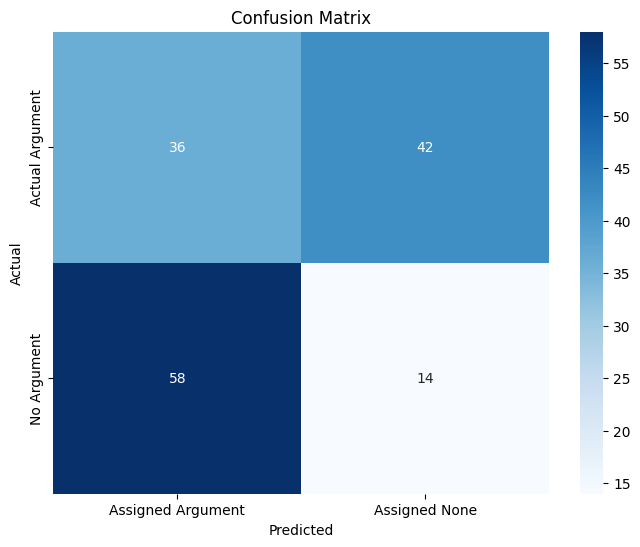

In [170]:
import matplotlib.pyplot as plt
import seaborn as sns  # optional for better heatmap visuals

# Data for the confusion matrix
confusion_data = {
    "Assigned Argument": [TP, FP],  # Predicted Argument Assigned
    "Assigned None": [FN, TN]       # Predicted None
}

confusion_matrix = pd.DataFrame(
    confusion_data, 
    index=["Actual Argument", "No Argument"]
)

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")

# Add labels and title
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [171]:
# Initialize counts
TP_category = 0  # True Positive
FP_category = 0  # False Positive
FP_category2 = 0  # False Positive
FN_category = 0  # False Negative
TN_category = 0  # True Negative

# Evaluate each row
for index, row in df_evaluation.iterrows():
    actual_category, predicted_category = row["actual_category"], row["predicted_category"]
    if actual_category == predicted_category and actual_category != "Unknown Category":
        TP_category += 1  # Correct argument assigned
    elif actual_category == "Unknown Category" and predicted_category == "Unknown Category":
        TN_category += 1  # No cateogry was given and none was predicted
    elif actual_category != "Unknown Category" and predicted_category == "Unknown Category":
        FN_category += 1  # No argument was assigned
    elif actual_category != predicted_category and actual_category == "Unknown Category":
        FP_category2 += 1  # Argument assigned when no should be
    elif actual_category != predicted_category:
        FP_category += 1  # Wrong argument assigned

# Print counts
print(f"True Positives (TP): {TP_category}")
print(f"False Positives (FP): {FP_category}")
print(f"False Positives 2 (FP): {FP_category2}")
print(f"False Negatives (FN): {FN_category}")
print(f"True Negatives (TN): {TN_category}")

# Calculate precision_category, recall_category, and F1_category score
precision_category = TP_category / (TP_category + FP_category) if (TP_category + FP_category) > 0 else 0
recall_category = TP_category / (TP_category + FN_category) if (TP_category + FN_category) > 0 else 0
f1_category = 2 * (precision_category * recall_category) / (precision_category + recall_category) if (precision_category + recall_category) > 0 else 0

print(f"Precision_category: {precision_category}")
print(f"Recall_category: {recall_category}")
print(f"F1_category Score: {f1_category}")


True Positives (TP): 52
False Positives (FP): 30
False Positives 2 (FP): 12
False Negatives (FN): 41
True Negatives (TN): 15
Precision_category: 0.6341463414634146
Recall_category: 0.5591397849462365
F1_category Score: 0.5942857142857142


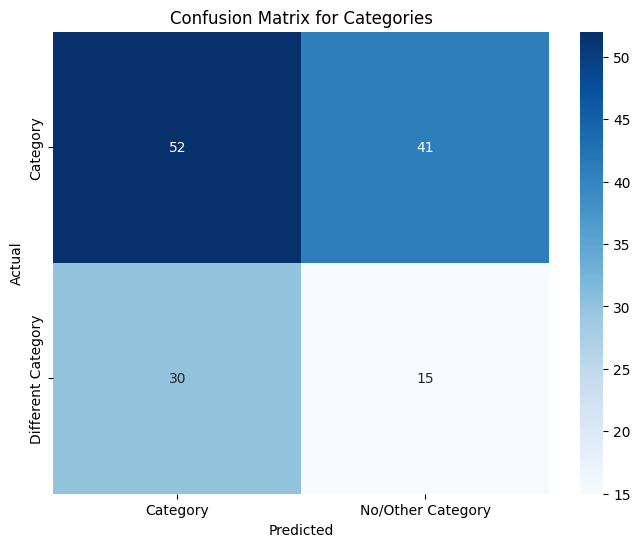

In [172]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Confusion matrix data
confusion_data_category = {
    "Category": [TP_category, FP_category],
    "No/Other Category": [FN_category, TN_category]    
}

# Create a DataFrame for the confusion matrix
confusion_matrix_category = pd.DataFrame(
    confusion_data_category, 
    index=["Category", "Different Category"]  # Row labels
)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_category, annot=True, fmt="d", cmap="Blues")

# Add labels and title
plt.title("Confusion Matrix for Categories")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Testing Over

In [ ]:
#Orinigal for Production!

"""# Define the classification and analysis function
def classify_and_analyze(sentence, kw_model, keywords_dict, precomputed_seed_embeddings, seed_words, threshold=0.7):
    # Extract keywords with KeyBERT
    keywords = kw_model.extract_keywords(
        sentence, top_n=5, seed_keywords=seed_words
    )
    extracted_keywords = [kw[0] for kw in keywords]

    # Initialize results
    categories = []
    for category, arguments in keywords_dict.items():
        for argument, seed_words in arguments.items():
            # Use precomputed embeddings for the argument
            seed_embeddings = precomputed_seed_embeddings[argument]

            if len(extracted_keywords) == 0:
                continue  # Skip to the next category if no keywords are extracted


            keyword_embeddings = sentence_transformer.encode(extracted_keywords)
            if keyword_embeddings.shape[0] == 0 or seed_embeddings.shape[0] == 0:
                continue  # Skip computation if embeddings are empty

            if keyword_embeddings.shape[1] != seed_embeddings.shape[1]:
                print(f"Dimension mismatch: {keyword_embeddings.shape} vs {seed_embeddings.shape}")
                continue  # Skip incompatible embeddings

            # Compute cosine similarities
            similarities = cosine_similarity(keyword_embeddings, seed_embeddings)
            max_similarity = similarities.max() if similarities.size > 0 else 0
            if max_similarity >= threshold:
                categories.append(argument)
    
    # Use FinancialBERT to classify sentiment
    sentiment_result = financial_bert_sentiment(sentence)[0]
    sentiment = sentiment_result['label']

    return categories, sentiment

# Prepare the DataFrame for processing
df_sentences['arguments'] = None
df_sentences['sentiment'] = None

from transformers import AutoTokenizer

# Load the tokenizer for your model
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")  # Replace with your model

def truncate_text(text, max_length=512):
    encoded = tokenizer.encode(text, truncation=True, max_length=max_length, add_special_tokens=True)
    return tokenizer.decode(encoded, skip_special_tokens=True)

# Truncate sentence before passing it to the model
for idx, row in df_sentences.iterrows():
    sentence = truncate_text(row['sentence'], max_length=512)
    categories, sentiment = classify_and_analyze(
        sentence, kw_model, keywords_dict, precomputed_seed_embeddings, seed_words
    )
    df_sentences.at[idx, 'arguments'] = categories
    df_sentences.at[idx, 'sentiment'] = sentiment



"""# Test the function on individual sentences
for sentence in df_sentences['sentence']:
    categories, sentiment = classify_and_analyze(sentence, kw_model, keywords_dict, precomputed_seed_embeddings, seed_words)
    print(f"Sentence: {sentence}\nCategories: {categories}, Sentiment: {sentiment}\n")
""""""

In [24]:
df_sentences

,Unnamed: 0,document_id,paragraph_id,sentence_id,sentence,arguments,sentiment
0,0,1,1,1,BUY INVESTMENT HIGHLIGHTS: $150.00 We raise ou...,"[Return On Equity, Investments]",positive
1,1,1,1,2,We now expect 3Q16 revenue of $6.855B up 52% y...,"[Revenue, Margins]",positive
2,2,1,1,3,"FB will report 3Q16 earnings on Wednesday, Nov...","[EPS, Revenue]",neutral
3,3,1,1,4,"The call in number is , ID .",[],neutral
4,4,1,1,6,Advertising We maintain our Buy rating and $15...,[],positive
...,...,...,...,...,...,...,...
35101,35101,927,4,1,A looming threat for all web publishers relate...,[],neutral
35102,35102,927,4,2,established by governments which limit how pub...,[Marketing],neutral
35103,35103,927,4,3,Rules could be established in the future which...,"[Revenue, Margins, Research & Development]",negative
35104,35104,927,5,1,Google has become so OTHER GOVERNMENT REGULATI...,"[Market Share, Market Expansion, Industry Outl...",neutral


In [25]:
df_sentences.to_csv("argument_sentiment_testing.csv")

In [ ]:
"""# Initialize AdaptKeyBERT and SentenceTransformer
kw_model = KeyBERT()
sentence_transformer = SentenceTransformer('all-MiniLM-L6-v2')

precomputed_seed_embeddings = {
    argument: sentence_transformer.encode(seed_words)
    for category, arguments in keywords_dict.items()
    for argument, seed_words in arguments.items()
}

# Flattening the keywords into a single list
seed_words = [
    argument 
    for category, arguments in keywords_dict.items() 
    for argument, keywords in arguments.items() 
    for keyword in keywords
]

def classify_sentence(sentence, kw_model, keywords_dict, precomputed_seed_embeddings, seed_words, threshold=0.65):
    # Extract keywords from the sentence using KeyBERT (zero-shot training)
    keywords = kw_model.extract_keywords(
        sentence, top_n=5, seed_keywords=seed_words, nr_candidates=50
    )
    extracted_keywords = [kw[0] for kw in keywords]

    results = {}
    for category, arguments in keywords_dict.items():
        argument_scores = {}
        for argument, seed_words in arguments.items():
            # Use precomputed embeddings for the argument
            seed_embeddings = precomputed_seed_embeddings[argument]
            # Encode the extracted keywords
            keyword_embeddings = sentence_transformer.encode(extracted_keywords)
            # Compute cosine similarities
            similarities = cosine_similarity(keyword_embeddings, seed_embeddings)
            max_similarity = similarities.max() if similarities.size > 0 else 0
            if max_similarity >= threshold:
                argument_scores[argument] = max_similarity
        
        if argument_scores:
            results[category] = argument_scores
    
    return results if results else {"Uncategorized": "No relevant category found"}

# Global list of seed_words for KeyBERT zero-shot training
seed_words = [
    keyword
    for category, arguments in keywords_dict.items()
    for argument, keywords in arguments.items()
    for keyword in keywords
]

# Test the function on sentences
for sentence in df_sentences['sentence']:
    categories = classify_sentence(sentence, kw_model, keywords_dict, precomputed_seed_embeddings, seed_words)
    print(f"Sentence: {sentence}\nCategories: {categories}\n")
"""

Sentence: Q4 was solid, highlighted by 32 billings growth yy, 80.00 which suggests the health of fundamentals and secular trends.
Categories: {'Company': {'Long-term Growth': 0.7785666}, 'Market': {'Industry Outlook': 0.7731363}}

Sentence: One of the highlights on the call was the early success of recently introduced Wave Analytics, including wins at marquee logos such as Time Warner Cable, Merck, and others, which suggests the credibility of the product cyclegrowth engine against what looks like a massive multi billion dollar market opportunity.
Categories: {'Uncategorized': 'No relevant category found'}

Sentence: Another standout on the call was the number of SaaSApplication Software 8figure deals, which likely reflects the companys industry vertical positioning, the strategic nature of relationships and comprehensive platform strategy.
Categories: {'Financial Performance': {'Investments': 0.7786581}, 'Market': {'Market Share': 0.66499156, 'Competitors': 0.764099, 'Industry Outlook